In [11]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true' 
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')

In [12]:
# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

from langchain_community.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings

embed = OllamaEmbeddings(
    model="llama3.2"
)
vectorstore = Chroma.from_documents(documents=splits, embedding=embed)

retriever = vectorstore.as_retriever()

In [13]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import ChatOllama

llm = ChatOllama(model = "llama3.2",temperature=0) 
generate_queries = (
    prompt_perspectives 
    | llm
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

## Langsmith trace 
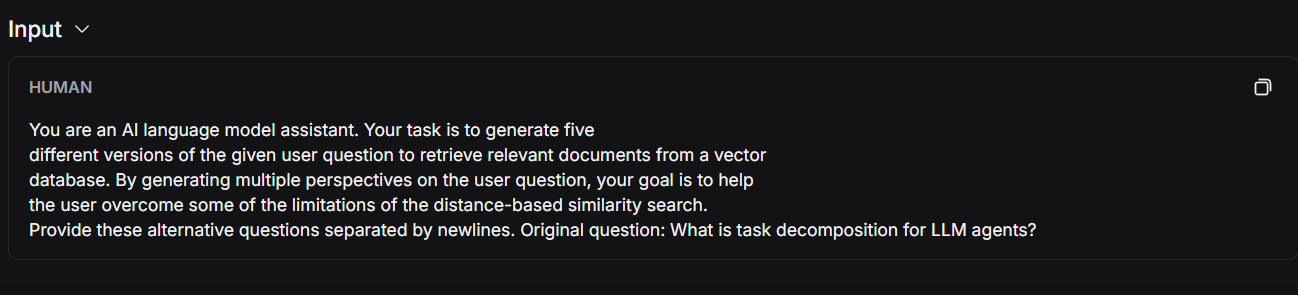
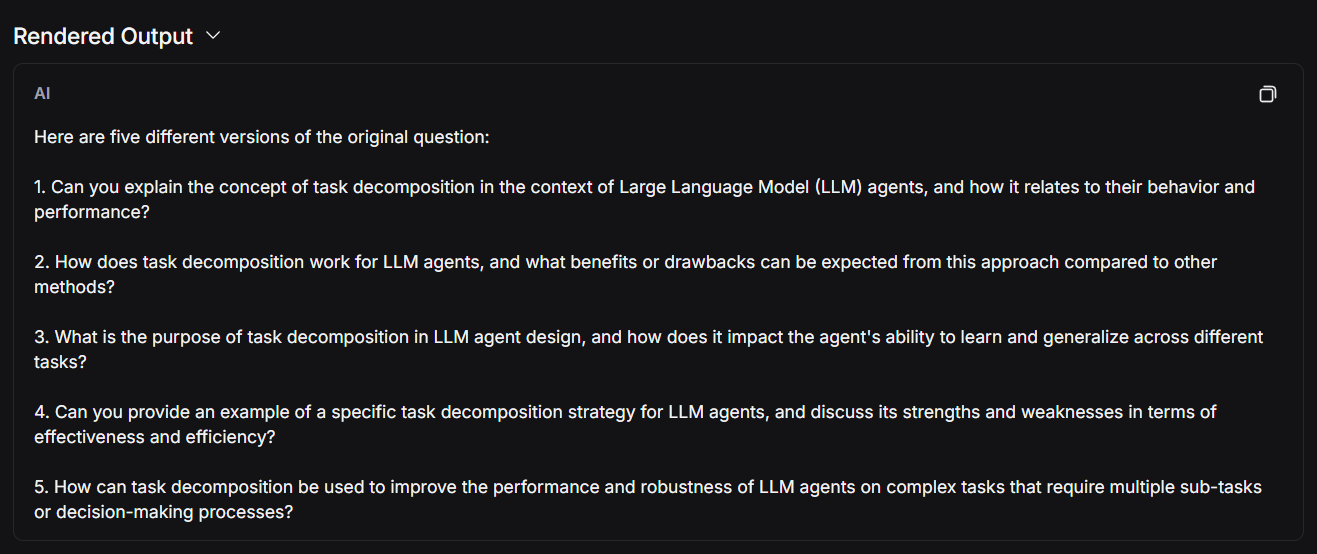

In [14]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

8

## Overall Workflow

<ul>
<li>Generate Multiple Perspectives: The original question is processed to create multiple alternative versions to improve retrieval effectiveness.</li>
<li>Retrieve Relevant Documents: The system queries a vector database using the generated questions to fetch relevant documents, ensuring uniqueness in the results.</li>
<li>Answer Generation: The retrieved documents serve as context for answering the original question through a RAG approach, effectively combining information retrieval with generative AI capabilities. </li>
<li>This workflow is designed to enhance the relevance and quality of responses generated by AI models when dealing with user queries, particularly in scenarios where context and varied phrasing can significantly impact retrieval effectiveness. </li>
</ul>

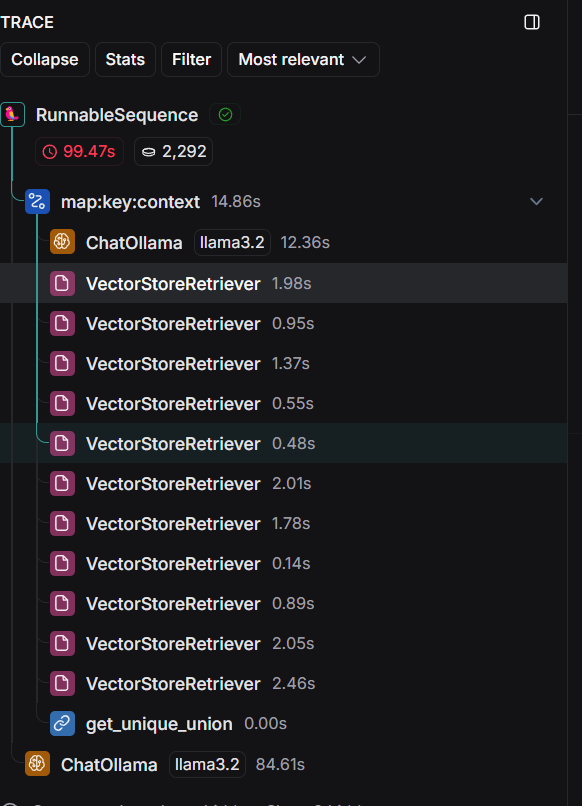

In [16]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down complex tasks into smaller, more manageable sub-tasks. This allows the agent to focus on one task at a time and improve its performance on each individual task.\n\nIn the context of the provided documents, task decomposition is mentioned in relation to the ReAct prompt template, which incorporates explicit steps for LLMs to think, such as "Thought: ...", "Action: ...", and "Observation: ...". This template helps the agent to break down complex tasks into smaller sub-tasks and provide more structured input.\n\nTask decomposition can also be seen in the context of generative agents, where the design combines LLM with memory, planning, and reflection mechanisms to enable agents to behave conditioned on past experience. The task decomposition here refers to the process of parsing user requests into multiple tasks, using few-shot examples to guide the LLM to do task parsing and planning.\n\nIn g